# Exploratory Data Analysis of the Pokemon_data.db

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ipywidgets as widgets

### Basic Function for executing query and fetching all for Querying.

In [4]:
# Function to execute SQL query and return results
def execute_query(query):
    '''
    Executes the given SQL query on a SQLite database and returns the results.

    Parameters:
        query (str): The SQL query to execute.

    Returns:
        list of tuples: A list containing the rows returned by the query. Each row is represented as a tuple.
    '''
    # Connect to the database
    conn = sqlite3.connect('pokemon_data.db')
    cursor = conn.cursor()
    cursor.execute(query)
    # Fetch all rows
    rows = cursor.fetchall()
    # Close cursor and connection
    cursor.close()
    conn.close()
    return rows

## EDA

###     What are the different Pokémon species in the Pokédex?

In [12]:
query = """
SELECT DISTINCT name
FROM pokedex;
"""
results = execute_query(query)
names=[]

#Appending the Species to a list
for name, in results:
    names.append(name)

#printing the first 12 species in the pokedex
print("The First 20 pokemon in the Pokedex are: ")
for i in range(0,20):
    print("\t",names[i])

The First 20 pokemon in the Pokedex are: 
	 bulbasaur
	 ivysaur
	 venusaur
	 charmander
	 charmeleon
	 charizard
	 squirtle
	 wartortle
	 blastoise
	 caterpie
	 metapod
	 butterfree
	 weedle
	 kakuna
	 beedrill
	 pidgey
	 pidgeotto
	 pidgeot
	 rattata
	 raticate


In [5]:
len(names)

1025

### Which Pokémon have the highest attack and defense?

In [6]:
query = """
SELECT name, attack, defense
FROM stats
ORDER BY attack DESC, defense DESC
LIMIT 10;
"""
results = execute_query(query)

#pokemon with highest stat in attack and defense in DF pokemon_df
pokemon_df=pd.DataFrame(results, columns=['name', 'attack', 'defense'])

#Print the DF
pokemon_df

,name,attack,defense
0,kartana,181.0,131.0
1,rampardos,165.0,60.0
2,regigigas,160.0,110.0
3,slaking,160.0,100.0
4,groudon,150.0,140.0
5,zekrom,150.0,120.0
6,rayquaza,150.0,90.0
7,deoxys-normal,150.0,50.0
8,haxorus,147.0,90.0
9,glastrier,145.0,130.0


### How many Pokemon in each generation?

In [7]:
query = """
SELECT generation, COUNT(*) as pokemon_count
FROM evolutions
GROUP BY generation;
"""

results = execute_query(query)

tot=0 #Find the Total Number of Pokemon in the Pokemon Universe till date

# Print the results
for generation,count in results:
    print(f"Generation '{generation}' has '{count}' Pokemons.")
    tot += count
print(f"The Pokemon universe has in total '{tot}' Pokemons.")

Generation '1' has '151' Pokemons.
Generation '2' has '100' Pokemons.
Generation '3' has '135' Pokemons.
Generation '4' has '107' Pokemons.
Generation '5' has '156' Pokemons.
Generation '6' has '72' Pokemons.
Generation '7' has '88' Pokemons.
Generation '8' has '96' Pokemons.
Generation '9' has '120' Pokemons.
The Pokemon universe has in total '1025' Pokemons.


###     What is the distribution of Pokémon types (primary and secondary) in the Pokédex?

In [8]:
query = """
SELECT primary_type, COUNT(*) as count
FROM pokedex
GROUP BY primary_type
"""
results = execute_query(query)

#Creating types_df DataFrame
types_df=pd.DataFrame(results, columns=['primary_type', 'count'])

#Print the output of the Query
types_df

,primary_type,count
0,bug,83
1,dark,45
2,dragon,37
3,electric,59
4,fairy,29
5,fighting,40
6,fire,66
7,flying,9
8,ghost,35
9,grass,103


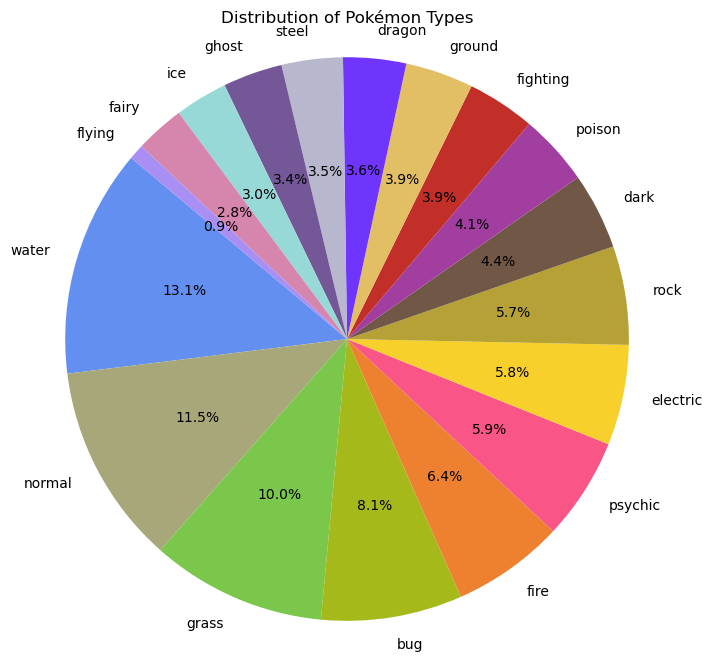

In [9]:
# Define a dictionary to map each type to its corresponding color
type_colors = {
    'normal': '#A8A77A',
    'fire': '#EE8130',
    'water': '#6390F0',
    'electric': '#F7D02C',
    'grass': '#7AC74C',
    'ice': '#96D9D6',
    'fighting': '#C22E28',
    'poison': '#A33EA1',
    'ground': '#E2BF65',
    'flying': '#A98FF3',
    'psychic': '#F95587',
    'bug': '#A6B91A',
    'rock': '#B6A136',
    'ghost': '#735797',
    'dragon': '#6F35FC',
    'dark': '#705746',
    'steel': '#B7B7CE',
    'fairy': '#D685AD'
}

# Sort the DataFrame by count in descending order
types_df_sorted = types_df.sort_values(by='count', ascending=False)

# Ploting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(types_df_sorted['count'], labels=types_df_sorted['primary_type'], autopct='%1.1f%%', startangle=140, colors=[type_colors[type_] for type_ in types_df_sorted['primary_type']])
plt.title('Distribution of Pokémon Types')
plt.axis('equal')
plt.show()

In [16]:
query = """
SELECT primary_type,secondary_type, COUNT(*) as count
FROM pokedex
GROUP BY primary_type , secondary_type
"""
results = execute_query(query)

# Creating the types_df DataFrame
types_df=pd.DataFrame(results, columns=['primary_type', 'secondary_type', 'count'])

types_df

,primary_type,secondary_type,count
0,bug,None,23
1,bug,dark,1
2,bug,electric,4
3,bug,fairy,2
4,bug,fighting,4
...,...,...,...
198,water,ice,4
199,water,poison,3
200,water,psychic,6
201,water,rock,5


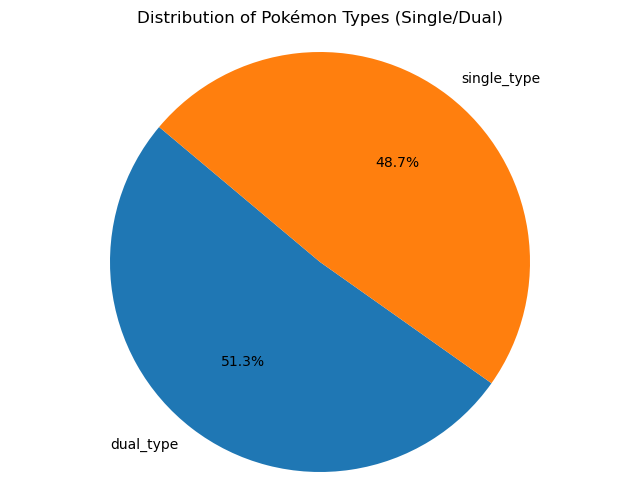

In [19]:
# Grouping based on secondary type
types_df['type_group'] = types_df['secondary_type'].apply(lambda x: 'single_type' if x == None else 'dual_type')

# Summing counts for each group
grouped_df = types_df.groupby('type_group')['count'].sum()

# Plotting pie chart
plt.figure(figsize=(8, 6))
plt.pie(grouped_df, labels=grouped_df.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Pokémon Types (Single/Dual)')
plt.axis('equal') 
plt.show()

### How does the height, weight and stats of Pokémons vary across different types?

In [10]:
query = """
SELECT p.primary_type,
       AVG(p.height) AS avg_height,
       AVG(p.weight) AS avg_weight,
       AVG(s.hp) AS avg_hp,
       AVG(s.attack) AS avg_attack,
       AVG(s.defense) AS avg_defense,
       AVG(s.special_attack) AS avg_special_attack,
       AVG(s.special_defense) AS avg_special_defense,
       AVG(s.speed) AS avg_speed,
       AVG(s.hp) + AVG(s.attack) + AVG(s.defense) + AVG(s.special_attack) + AVG(s.special_defense) + AVG(s.speed) as Avg_total_stats
FROM pokedex p
JOIN stats s ON p.name = s.name
GROUP BY p.primary_type;
"""
results = execute_query(query)

# Create the DataFrame
hw_df=pd.DataFrame(results, columns=['Type', 'Avg_height', 'Avg_weight','Avg_hp','Avg_attack','Avg_defense','Avg_special_attack','Avg_special_defense','Avg_speed','Avg_total_stats'])

# Print the output
hw_df[['Type', 'Avg_hp','Avg_attack','Avg_defense','Avg_special_attack','Avg_special_defense','Avg_speed','Avg_total_stats']]

,Type,Avg_hp,Avg_attack,Avg_defense,Avg_special_attack,Avg_special_defense,Avg_speed,Avg_total_stats
0,bug,56.493976,67.554217,69.578313,56.433735,63.313253,61.265060,374.638554
1,dark,75.800000,88.000000,71.622222,72.933333,70.755556,75.622222,454.733333
2,dragon,79.594595,98.972973,75.216216,78.486486,77.702703,80.189189,490.162162
3,electric,64.779661,72.966102,62.101695,84.830508,66.559322,85.067797,436.305085
4,fairy,71.379310,66.827586,70.965517,76.103448,85.793103,65.000000,436.068966
5,fighting,76.075000,102.700000,72.350000,53.175000,67.275000,69.975000,441.550000
6,fire,69.833333,82.606061,66.833333,83.272727,69.545455,74.106061,446.196970
7,flying,70.000000,79.888889,66.000000,68.444444,68.777778,83.000000,436.111111
8,ghost,61.800000,68.600000,75.485714,84.114286,80.828571,60.342857,431.171429
9,grass,65.766990,74.349515,70.893204,73.262136,69.300971,59.543689,413.116505


In [6]:
hw_df['Avg_height'] = hw_df['Avg_height']/10
hw_df['Avg_weight'] = hw_df['Avg_weight']/10
hw_df[['Type','Avg_height','Avg_weight']]

,Type,Avg_height,Avg_weight
0,bug,0.877108,32.226506
1,dark,1.320000,78.380000
2,dragon,1.800000,104.967568
3,electric,1.096610,52.364407
4,fairy,0.841379,28.703448
5,fighting,1.310000,74.920000
6,fire,1.201515,70.690909
7,flying,1.177778,38.522222
8,ghost,1.148571,55.611429
9,grass,0.909709,31.450485


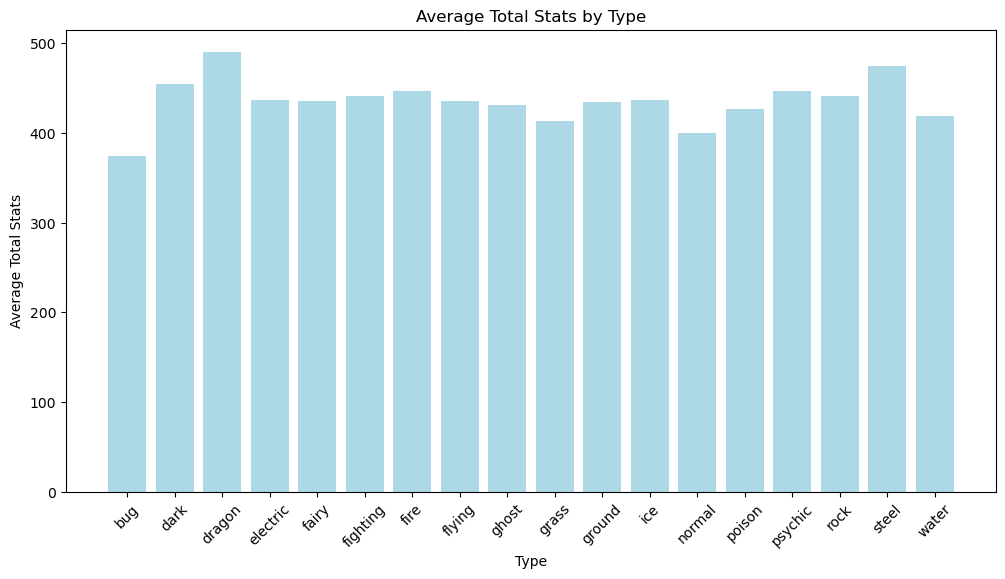

In [7]:
# Ploting average total stats by type
plt.figure(figsize=(12, 6))
plt.bar(hw_df['Type'], hw_df['Avg_total_stats'], color='lightblue')
plt.xlabel('Type')  
plt.ylabel('Average Total Stats')  
plt.title('Average Total Stats by Type')  
plt.xticks(rotation=45)  
plt.show()  

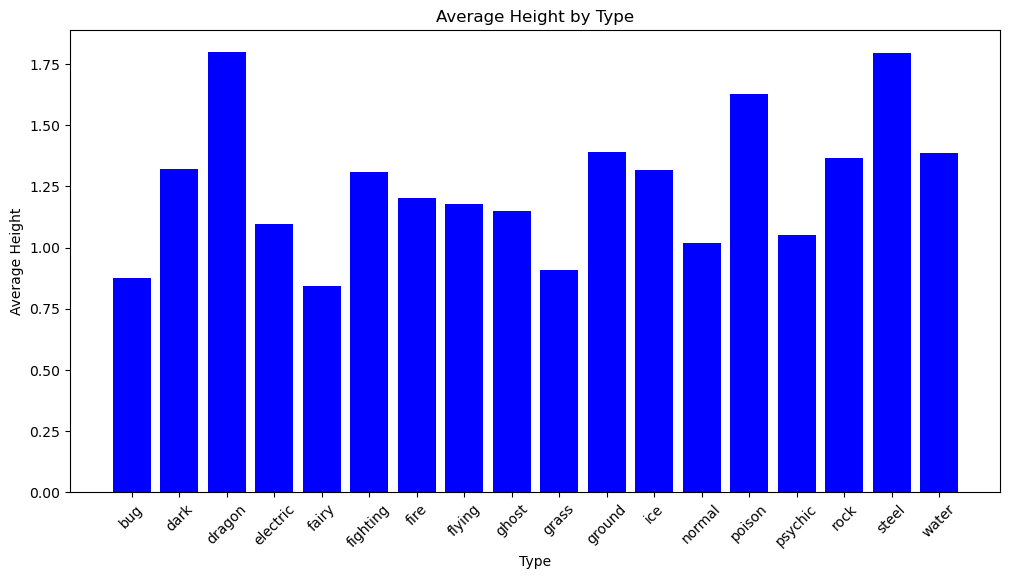

In [8]:
# Plot average height by type
plt.figure(figsize=(12, 6))  
plt.bar(hw_df['Type'], hw_df['Avg_height'], color='Blue')
plt.xlabel('Type')  
plt.ylabel('Average Height')  
plt.title('Average Height by Type')  
plt.xticks(rotation=45)
plt.show()

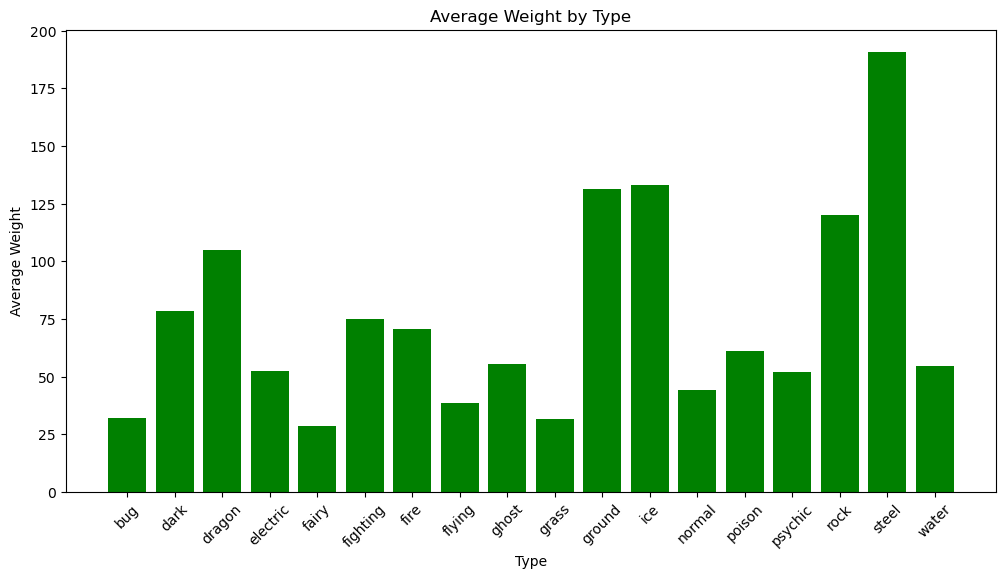

In [9]:
# Plot average weight by type
plt.figure(figsize=(12, 6))  
plt.bar(hw_df['Type'], hw_df['Avg_weight'], color='green')
plt.xlabel('Type')  
plt.ylabel('Average Weight')  
plt.title('Average Weight by Type')  
plt.xticks(rotation=45) 
plt.show()  

### Which Pokémon have the highest and lowest base stats (HP, Attack, Defense, Special Attack, Special Defense, Speed)?

In [73]:
#Highest HP
query = """
SELECT name, hp
FROM stats
ORDER BY hp DESC
LIMIT 1;
"""
stats = []

high_hp = execute_query(query)
# Print the results
for name,hp in high_hp:
    # Append values to list
    stats.append({'name': name, 'category': 'HP', 'stat': hp})
    print(f"The Pokemon with the Highest HP is '{name.title()}' with a HP of '{hp}'")

The Pokemon with the Highest HP is 'Blissey' with a HP of '255.0'


In [74]:
#Lowest HP
query = """
SELECT name, hp
FROM stats
ORDER BY hp ASC
LIMIT 1;
"""
low_hp = execute_query(query)
# Print the results
for name,hp in low_hp:
    stats.append({'name': name, 'category': 'HP', 'stat': hp})
    print(f"The Pokemon with the Lowest HP is '{name.title()}' with a HP of {hp}")

The Pokemon with the Lowest HP is 'Shedinja' with a HP of 1.0


In [75]:
#Highest Attack
query = """
SELECT name, attack
FROM stats
ORDER BY attack DESC
LIMIT 1;
"""
high_attack = execute_query(query)
# Print the results
for name,attack in high_attack:
    stats.append({'name': name, 'category': 'Attack', 'stat': attack})
    print(f"The Pokemon with the Highest Attack is '{name.title()}' with an Attack of '{attack}'")

The Pokemon with the Highest Attack is 'Kartana' with an Attack of '181.0'


In [76]:
#Lowest Attack
query = """
SELECT name, attack
FROM stats
ORDER BY attack ASC
LIMIT 1;
"""
low_attack = execute_query(query)
# Print the results
for name,attack in low_attack:
    stats.append({'name': name, 'category': 'Attack', 'stat': attack})
    print(f"The Pokemon with the Lowest Attack is '{name.title()}' with an Attack of '{attack}'")

The Pokemon with the Lowest Attack is 'Chansey' with an Attack of '5.0'


In [77]:
#Highest Defense
query = """
SELECT name, defense
FROM stats
ORDER BY defense DESC
LIMIT 1;
"""
high_defense = execute_query(query)
# Print the results
for name,defense in high_defense:
    stats.append({'name': name, 'category': 'Defense', 'stat': defense})
    print(f"The Pokemon with the Highest Defense is '{name.title()}' with a Defense of '{defense}'")

The Pokemon with the Highest Defense is 'Shuckle' with a Defense of '230.0'


In [78]:
#lowest Defense
query = """
SELECT name, defense
FROM stats
ORDER BY defense ASC
LIMIT 1;
"""
low_defense = execute_query(query)
# Print the results
for name,defense in low_defense:
    stats.append({'name': name, 'category': 'Defense', 'stat': defense})
    print(f"The Pokemon with the Lowest Defense is '{name.title()}' with a Defense of '{defense}'")

The Pokemon with the Lowest Defense is 'Chansey' with a Defense of '5.0'


In [79]:
#Highest Special Attack
query = """
SELECT name, special_attack
FROM stats
ORDER BY special_attack DESC
LIMIT 1;
"""
high_special_attack = execute_query(query)
# Print the results
for name,spl_attack in high_special_attack:
    stats.append({'name': name, 'category': 'Special Attack', 'stat': spl_attack})
    print(f"The Pokemon with the Highest Speical Attack is '{name.title()}' with a Special Attack of '{spl_attack}'")

The Pokemon with the Highest Speical Attack is 'Xurkitree' with a Special Attack of '173.0'


In [80]:
#Lowest Special Attack
query = """
SELECT name, special_attack
FROM stats
ORDER BY special_attack ASC
LIMIT 1;
"""
low_special_attack = execute_query(query)
# Print the results
for name,spl_attack in low_special_attack:
    stats.append({'name': name, 'category': 'Special Attack', 'stat': spl_attack})
    print(f"The Pokemon with the Lowest Speical Attack is '{name.title()}' with a Special Attack of '{spl_attack}'")

The Pokemon with the Lowest Speical Attack is 'Shuckle' with a Special Attack of '10.0'


In [81]:
#Highest Special Defense
# Example usage: Running a SQL query
query = """
SELECT name, special_defense
FROM stats
ORDER BY special_defense DESC
LIMIT 1;
"""
highest_special_defense = execute_query(query)
# Print the results
for name,spl_defense in highest_special_defense:
    stats.append({'name': name, 'category': 'Special Defense', 'stat': spl_defense})
    print(f"The Pokemon with the Highest Speical Defense is '{name.title()}' with a Special Defense of '{spl_defense}'")

The Pokemon with the Highest Speical Defense is 'Shuckle' with a Special Defense of '230.0'


In [82]:
#Lowest Special Defense
query = """
SELECT name, special_defense
FROM stats
ORDER BY special_defense ASC
LIMIT 1;
"""
lowest_special_defense = execute_query(query)
# Print the results
for name,spl_defense in lowest_special_defense:
    stats.append({'name': name, 'category': 'Special Defense', 'stat': spl_defense})
    print(f"The Pokemon with the Lowest Speical Defense is '{name.title()}' with a Special Defense of '{spl_defense}'")

The Pokemon with the Lowest Speical Defense is 'Caterpie' with a Special Defense of '20.0'


In [83]:
#Highest Speed
query = """
SELECT name, speed
FROM stats
ORDER BY speed DESC
LIMIT 1;
"""
highest_speed = execute_query(query)
# Print the results
for name,speed in highest_speed:
    stats.append({'name': name, 'category': 'Speed', 'stat': speed})
    print(f"The Pokemon with the Highest Speed is '{name.title()}' with a Speed of '{speed}'")

The Pokemon with the Highest Speed is 'Regieleki' with a Speed of '200.0'


In [84]:
#Lowest Speed
query = """
SELECT name, speed
FROM stats
ORDER BY speed ASC
LIMIT 1;
"""
low_speed = execute_query(query)
# Print the results
for name,speed in low_speed:
    stats.append({'name': name, 'category': 'Speed', 'stat': speed})
    print(f"The Pokemon with the Lowest Speed is '{name.title()}' with a Speed of '{speed}'")

The Pokemon with the Lowest Speed is 'Shuckle' with a Speed of '5.0'


In [87]:
stats_df = pd.DataFrame(stats)
stats_df

,name,category,stat
0,blissey,HP,255.0
1,shedinja,HP,1.0
2,kartana,Attack,181.0
3,chansey,Attack,5.0
4,shuckle,Defense,230.0
5,chansey,Defense,5.0
6,xurkitree,Special Attack,173.0
7,shuckle,Special Attack,10.0
8,shuckle,Special Defense,230.0
9,caterpie,Special Defense,20.0


### How many evolutions exist for each Pokémon, and what are their names?

In [89]:
query = """
SELECT e.id, e.name,
       (SELECT GROUP_CONCAT(e2.evolves_to) 
        FROM evolutions e2 
        WHERE e2.id = e.id 
        AND e2.evolves_to IS NOT NULL) AS evolution_names
FROM evolutions e
GROUP BY e.id;
"""
results = execute_query(query)
evolutions_df = pd.DataFrame(results, columns=['id','name','evolves_to'])

# Replace 'NaN' strings in evolves_to with actual NaN values
evolutions_df['evolves_to'] = evolutions_df['evolves_to'].replace('null', np.nan)

# Convert strings in 'evolves_to' column to lists
evolutions_df['evolves_to'] = evolutions_df['evolves_to'].apply(lambda x: json.loads(x) if pd.notna(x) else [])

# Count the number of elements in each list and store the result in a new column 'num_of_evolutions'
evolutions_df['num_of_evolutions'] = evolutions_df['evolves_to'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Sort the DataFrame in descending order of 'num_of_evolutions' 
evolutions_df_sorted = evolutions_df.sort_values(by='num_of_evolutions', ascending=False)
evolutions_df_sorted.head(19)

,id,name,evolves_to,num_of_evolutions
132,133,eevee,"[vaporeon, jolteon, flareon, espeon, umbreon, ...",8
839,840,applin,"[flapple, appletun, dipplin]",3
235,236,tyrogue,"[hitmonlee, hitmonchan, hitmontop]",3
934,935,charcadet,"[armarouge, ceruledge]",2
122,123,scyther,"[scizor, kleavor]",2
60,61,poliwhirl,"[poliwrath, politoed]",2
365,366,clamperl,"[huntail, gorebyss]",2
280,281,kirlia,"[gardevoir, gallade]",2
411,412,burmy,"[wormadam, mothim]",2
289,290,nincada,"[ninjask, shedinja]",2


### Which Pokémon have the highest and lowest total stats (HP, Attack, Defense, Special Attack, Special Defense, Speed) by generation, type and overall?

In [90]:
#Highest Stat among all Pokemon
query = """
SELECT name, hp + attack + defense + special_attack + special_defense + speed AS total_stats
FROM stats as s
ORDER BY total_stats DESC
LIMIT 1;
"""
highest_stat = execute_query(query)
# Print the results
for name, stat in highest_stat:
    print(f"The Pokemon with the Highest Total Stat is '{name.title()}' with a Total Stat of '{stat}'")

The Pokemon with the Highest Total Stat is 'Arceus' with a Total Stat of '720.0'


In [91]:
#Lowest Stat among all Pokemon
query = """
SELECT name, hp + attack + defense + special_attack + special_defense + speed AS total_stats
FROM stats as s
ORDER BY total_stats ASC
LIMIT 1;
"""
lowest_stat = execute_query(query)
# Print the results
for name, stat in lowest_stat:
    print(f"The Pokemon with the Lowest Total Stat is '{name.title()}' with a Total Stat of '{stat}'")

The Pokemon with the Lowest Total Stat is 'Wishiwashi-Solo' with a Total Stat of '175.0'


In [92]:
# Query to get the Pokémon with the Highest total stats in each Generation
query = """
SELECT s.name, 
       s.hp + s.attack + s.defense + s.special_attack + s.special_defense + s.speed AS total_stats,
       e.generation
FROM stats AS s
JOIN evolutions AS e ON s.id = e.id
JOIN (
    SELECT e.generation, MAX(s.hp + s.attack + s.defense + s.special_attack + s.special_defense + s.speed) AS max_total_stats
    FROM stats AS s
    JOIN evolutions AS e ON s.id = e.id
    GROUP BY e.generation
) AS max_stats_per_generation
ON e.generation = max_stats_per_generation.generation
AND s.hp + s.attack + s.defense + s.special_attack + s.special_defense + s.speed = max_stats_per_generation.max_total_stats
ORDER BY e.generation;
"""
highest_stat_df = pd.DataFrame(execute_query(query), columns=['Name', 'Total_Stats', 'Generation'])

#printing the output
highest_stat_df

,Name,Total_Stats,Generation
0,mewtwo,680.0,1
1,lugia,680.0,2
2,ho-oh,680.0,2
3,rayquaza,680.0,3
4,arceus,720.0,4
5,reshiram,680.0,5
6,zekrom,680.0,5
7,xerneas,680.0,6
8,yveltal,680.0,6
9,solgaleo,680.0,7


In [93]:
# Query to get the Pokémon with the lowest total stats in each generation
query_lowest = """
SELECT s.name, 
       s.hp + s.attack + s.defense + s.special_attack + s.special_defense + s.speed AS total_stats,
       e.generation
FROM stats AS s
JOIN evolutions AS e ON s.id = e.id
JOIN (
    SELECT e.generation, MIN(s.hp + s.attack + s.defense + s.special_attack + s.special_defense + s.speed) AS min_total_stats
    FROM stats AS s
    JOIN evolutions AS e ON s.id = e.id
    GROUP BY e.generation
) AS min_stats_per_generation
ON e.generation = min_stats_per_generation.generation
AND s.hp + s.attack + s.defense + s.special_attack + s.special_defense + s.speed = min_stats_per_generation.min_total_stats
ORDER BY e.generation;
"""

# Executing the query and storing the result in a DataFrame
lowest_stat_df = pd.DataFrame(execute_query(query_lowest), columns=['Name', 'Total_Stats', 'Generation'])

# Printing the output
lowest_stat_df


,Name,Total_Stats,Generation
0,caterpie,195.0,1
1,weedle,195.0,1
2,sunkern,180.0,2
3,azurill,190.0,3
4,kricketot,194.0,4
5,patrat,255.0,5
6,scatterbug,200.0,6
7,wishiwashi-solo,175.0,7
8,blipbug,180.0,8
9,tarountula,210.0,9


In [94]:
# Query to get the Pokémon with the lowest total stats for each primary type
query_lowest_type = """
SELECT s.name, 
       s.hp + s.attack + s.defense + s.special_attack + s.special_defense + s.speed AS total_stats,
       p.primary_type
FROM stats AS s
JOIN evolutions AS e ON s.id = e.id
JOIN pokedex AS p ON s.id = p.id
JOIN (
    SELECT p.primary_type, MIN(s.hp + s.attack + s.defense + s.special_attack + s.special_defense + s.speed) AS min_total_stats
    FROM stats AS s
    JOIN evolutions AS e ON s.id = e.id
    JOIN pokedex AS p ON s.id = p.id
    GROUP BY p.primary_type
) AS min_stats_per_type
ON p.primary_type = min_stats_per_type.primary_type
AND s.hp + s.attack + s.defense + s.special_attack + s.special_defense + s.speed = min_stats_per_type.min_total_stats
ORDER BY total_stats;
"""

# Executing the query and storing the result in a DataFrame
lowest_stat_type_df = pd.DataFrame(execute_query(query_lowest_type), columns=['Name', 'Total_Stats', 'Primary_Type'])

# Printing the output
lowest_stat_type_df


,Name,Total_Stats,Primary_Type
0,wishiwashi-solo,175.0,water
1,blipbug,180.0,bug
2,sunkern,180.0,grass
3,snom,185.0,ice
4,azurill,190.0,normal
5,ralts,198.0,psychic
6,pichu,205.0,electric
7,tyrogue,210.0,fighting
8,cleffa,218.0,fairy
9,poochyena,220.0,dark


In [96]:
# Query to get the Pokémon with the highest total stats for each primary type
query_highest_type = """
SELECT s.name, 
       s.hp + s.attack + s.defense + s.special_attack + s.special_defense + s.speed AS total_stats,
       p.primary_type
FROM stats AS s
JOIN evolutions AS e ON s.id = e.id
JOIN pokedex AS p ON s.id = p.id
JOIN (
    SELECT p.primary_type, MAX(s.hp + s.attack + s.defense + s.special_attack + s.special_defense + s.speed) AS max_total_stats
    FROM stats AS s
    JOIN evolutions AS e ON s.id = e.id
    JOIN pokedex AS p ON s.id = p.id
    GROUP BY p.primary_type
) AS max_stats_per_type
ON p.primary_type = max_stats_per_type.primary_type
AND s.hp + s.attack + s.defense + s.special_attack + s.special_defense + s.speed = max_stats_per_type.max_total_stats
ORDER BY total_stats DESC;
"""

# Executing the query and storing the result in a DataFrame
highest_stat_type_df = pd.DataFrame(execute_query(query_highest_type), columns=['Name', 'Total_Stats', 'Primary_Type'])

# Printing the output
highest_stat_type_df


,Name,Total_Stats,Primary_Type
0,arceus,720.0,normal
1,eternatus,690.0,poison
2,yveltal,680.0,dark
3,rayquaza,680.0,dragon
4,reshiram,680.0,dragon
5,zekrom,680.0,dragon
6,xerneas,680.0,fairy
7,ho-oh,680.0,fire
8,giratina-altered,680.0,ghost
9,mewtwo,680.0,psychic


###   How does the distribution of Pokémon types vary across different generations, considering both primary and secondary types?

In [97]:
query = """
SELECT p.primary_type, p.secondary_type, e.generation, COUNT(*) AS type_count
FROM pokedex AS p
JOIN evolutions AS e ON p.id = e.id
GROUP BY p.primary_type, p.secondary_type, e.generation
ORDER BY e.generation, type_count DESC;
"""

# Execute the query and store the result in a DataFrame
result = execute_query(query)

# Convert the result to a pandas DataFrame
result_df = pd.DataFrame(result, columns=['Primary_Type', 'Secondary_Type', 'Generation', 'Type_Count'])

# Display the DataFrame
result_df

,Primary_Type,Secondary_Type,Generation,Type_Count
0,water,None,1,18
1,normal,None,1,12
2,fire,None,1,10
3,poison,None,1,10
4,grass,poison,1,9
...,...,...,...,...
442,steel,ghost,9,1
443,steel,psychic,9,1
444,water,dragon,9,1
445,water,fighting,9,1


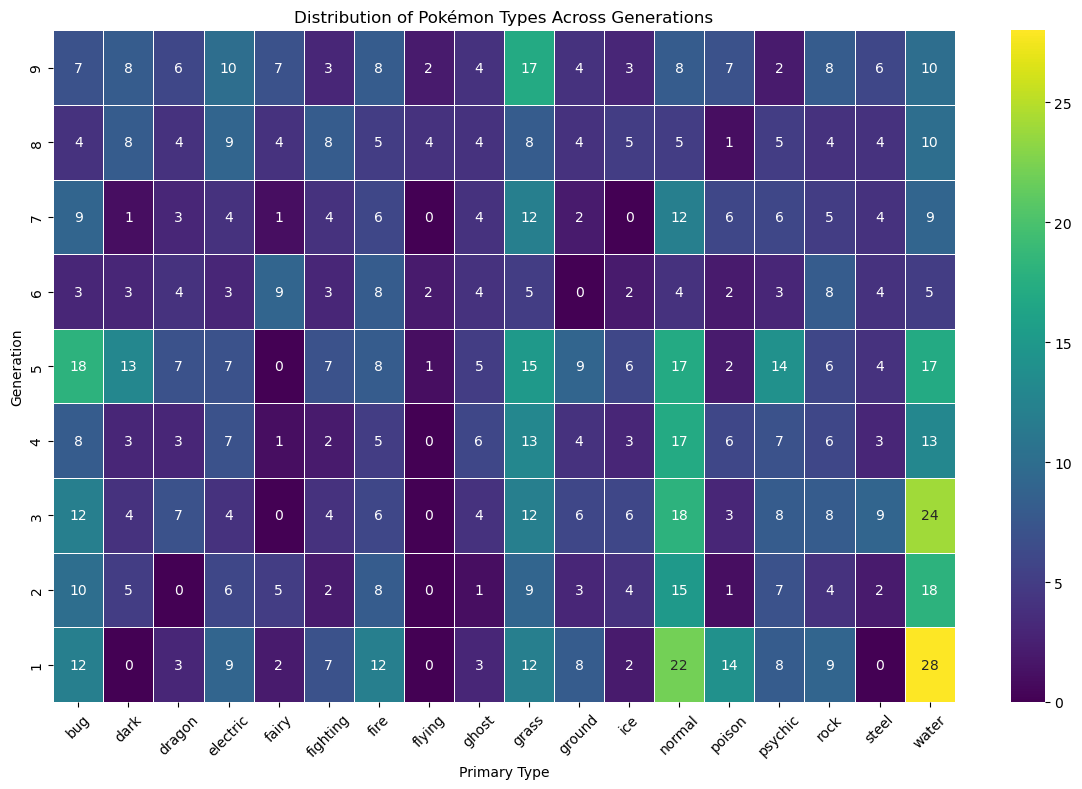

In [98]:
# Reverse the order of the index (generations)
pivot_df_reversed = pivot_df.iloc[::-1]

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df_reversed, cmap='viridis', annot=True, fmt='d', linewidths=0.5)
plt.title('Distribution of Pokémon Types Across Generations')
plt.xlabel('Primary Type')
plt.ylabel('Generation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### How does the average height and weight of Pokémon vary across different generations, considering both primary and secondary types?

In [11]:
query = """
SELECT e.generation, pd.primary_type, pd.secondary_type,
       AVG(pd.height) AS avg_height,
       AVG(pd.weight) AS avg_weight
FROM pokedex AS pd
JOIN evolutions AS e ON pd.id = e.id
GROUP BY e.generation, pd.primary_type, pd.secondary_type
ORDER BY e.generation, pd.primary_type, pd.secondary_type;
"""

# Execute the query and store the result in a DataFrame
result = execute_query(query)
# Convert the result to a pandas DataFrame
pokemon_stats_df = pd.DataFrame(result, columns=['Generation','Primary_Type', 'Secondary_Type', 'Avg_Height', 'Avg_Weight'])

pokemon_stats_df['Avg_Height'] = pokemon_stats_df['Avg_Height']/10
pokemon_stats_df['Avg_Weight'] = pokemon_stats_df['Avg_Weight']/10
# Display the DataFrame
pokemon_stats_df

,Generation,Primary_Type,Secondary_Type,Avg_Height,Avg_Weight
0,1,bug,None,0.833333,22.60
1,1,bug,flying,1.300000,44.00
2,1,bug,grass,0.650000,17.45
3,1,bug,poison,0.880000,17.04
4,1,dragon,None,2.900000,9.90
...,...,...,...,...,...
442,9,steel,psychic,1.600000,156.00
443,9,water,None,2.671429,53.60
444,9,water,dragon,3.500000,280.00
445,9,water,fighting,1.800000,61.90


### Type Effectiveness Analysis

In [12]:
query="""
select * from adv_types;
"""
result=execute_query(query)

# Convert the result to a pandas DataFrame
pokemon_type_adv_df = pd.DataFrame(result, columns=['my_types', 'opponent_normal', 'opponent_fighting', 'opponent_flying', 'opponent_poison', 'opponent_ground', 'opponent_rock', 'opponent_bug', 'opponent_ghost', 'opponent_steel', 'opponent_fire', 'opponent_water', 'opponent_grass', 'opponent_electric', 'opponent_psychic', 'opponent_ice', 'opponent_dragon', 'opponent_dark', 'opponent_fairy'])

# Display the DataFrame
pokemon_type_adv_df

,my_types,opponent_normal,opponent_fighting,opponent_flying,opponent_poison,opponent_ground,opponent_rock,opponent_bug,opponent_ghost,opponent_steel,opponent_fire,opponent_water,opponent_grass,opponent_electric,opponent_psychic,opponent_ice,opponent_dragon,opponent_dark,opponent_fairy
0,normal,Effective,Effective,Effective,Effective,Effective,Less Effective,Effective,No Damage,Less Effective,Effective,Effective,Effective,Effective,Effective,Effective,Effective,Effective,Effective
1,fighting,Super Effective,Effective,Less Effective,Less Effective,Effective,Super Effective,Less Effective,No Damage,Super Effective,Effective,Effective,Effective,Effective,Less Effective,Super Effective,Effective,Super Effective,Less Effective
2,flying,Effective,Super Effective,Effective,Effective,Effective,Less Effective,Super Effective,Effective,Less Effective,Effective,Effective,Super Effective,Less Effective,Effective,Effective,Effective,Effective,Effective
3,poison,Effective,Effective,Effective,Less Effective,Less Effective,Less Effective,Effective,Less Effective,No Damage,Effective,Effective,Super Effective,Effective,Effective,Effective,Effective,Effective,Super Effective
4,ground,Effective,Effective,No Damage,Super Effective,Effective,Super Effective,Less Effective,Effective,Super Effective,Super Effective,Effective,Less Effective,Super Effective,Effective,Effective,Effective,Effective,Effective
5,rock,Effective,Less Effective,Super Effective,Effective,Less Effective,Effective,Super Effective,Effective,Less Effective,Super Effective,Effective,Effective,Effective,Effective,Super Effective,Effective,Effective,Effective
6,bug,Effective,Less Effective,Less Effective,Less Effective,Effective,Effective,Effective,Less Effective,Less Effective,Less Effective,Effective,Super Effective,Effective,Super Effective,Effective,Effective,Super Effective,Less Effective
7,ghost,No Damage,Effective,Effective,Effective,Effective,Effective,Effective,Super Effective,Effective,Effective,Effective,Effective,Effective,Super Effective,Effective,Effective,Less Effective,Effective
8,steel,Effective,Effective,Effective,Effective,Effective,Super Effective,Effective,Effective,Less Effective,Less Effective,Less Effective,Effective,Less Effective,Effective,Super Effective,Effective,Effective,Super Effective
9,fire,Effective,Effective,Effective,Effective,Effective,Less Effective,Super Effective,Effective,Super Effective,Less Effective,Less Effective,Super Effective,Effective,Effective,Super Effective,Less Effective,Effective,Effective


In [13]:
# Create a dictionary to map effectiveness to numeric values
effectiveness_map = {
    'No Damage': 0.0, 
    'Less Effective': 0.5, 
    'Effective': 1.0, 
    'Super Effective': 2.0}

# Create a copy of the DataFrame to preserve the original
pokemon_type_adv_df_numeric = pokemon_type_adv_df.copy()

# Map the effectiveness values to numeric values for all columns except 'my_types'
pokemon_type_adv_df_numeric.iloc[:, 1:] = pokemon_type_adv_df_numeric.iloc[:, 1:].applymap(lambda x: effectiveness_map.get(x))

# Print the updated DataFrame
pokemon_type_adv_df_numeric


,my_types,opponent_normal,opponent_fighting,opponent_flying,opponent_poison,opponent_ground,opponent_rock,opponent_bug,opponent_ghost,opponent_steel,opponent_fire,opponent_water,opponent_grass,opponent_electric,opponent_psychic,opponent_ice,opponent_dragon,opponent_dark,opponent_fairy
0,normal,1.0,1.0,1.0,1.0,1.0,0.5,1.0,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,fighting,2.0,1.0,0.5,0.5,1.0,2.0,0.5,0.0,2.0,1.0,1.0,1.0,1.0,0.5,2.0,1.0,2.0,0.5
2,flying,1.0,2.0,1.0,1.0,1.0,0.5,2.0,1.0,0.5,1.0,1.0,2.0,0.5,1.0,1.0,1.0,1.0,1.0
3,poison,1.0,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0
4,ground,1.0,1.0,0.0,2.0,1.0,2.0,0.5,1.0,2.0,2.0,1.0,0.5,2.0,1.0,1.0,1.0,1.0,1.0
5,rock,1.0,0.5,2.0,1.0,0.5,1.0,2.0,1.0,0.5,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0
6,bug,1.0,0.5,0.5,0.5,1.0,1.0,1.0,0.5,0.5,0.5,1.0,2.0,1.0,2.0,1.0,1.0,2.0,0.5
7,ghost,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.5,1.0
8,steel,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.5,0.5,0.5,1.0,0.5,1.0,2.0,1.0,1.0,2.0
9,fire,1.0,1.0,1.0,1.0,1.0,0.5,2.0,1.0,2.0,0.5,0.5,2.0,1.0,1.0,2.0,0.5,1.0,1.0


In [14]:
def plot_effectiveness(selected_type):
    '''
    Plots the effectiveness of the selected Pokémon type against various opponent types.

    Parameters:
        selected_type (str): The Pokémon type selected from the dropdown menu.
    '''
    plt.figure(figsize=(10, 6))

    # Filter the DataFrame to get the row corresponding to the selected Pokémon type
    selected_row = pokemon_type_adv_df_numeric[pokemon_type_adv_df_numeric['my_types'] == selected_type]

    # Extract the effectiveness values for the selected type against each opponent type
    effectiveness_values = selected_row.iloc[:, 1:-1].values.flatten()

    # Extract the opponent types
    opponent_types = selected_row.columns[1:-1]

    # Sort the effectiveness values and opponent types in descending order
    sorted_indices = effectiveness_values.argsort()[::-1]
    sorted_effectiveness_values = effectiveness_values[sorted_indices]
    sorted_opponent_types = opponent_types[sorted_indices]

    # Plotting the bar chart
    bars = plt.bar(sorted_opponent_types, sorted_effectiveness_values, color='skyblue')
    plt.title(f'Effectiveness of {selected_type.capitalize()} Type Against Opponent Types')
    plt.xlabel('Opponent Type')
    plt.ylabel('Effectiveness')
    plt.xticks(rotation=45, ha='right')  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height, '%.1f' % height, ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Defining a function to handle changes in the dropdown value
def on_change(change):
    '''
    Handles changes in the dropdown value and triggers the corresponding visualization.

    Parameters:
        change (dict): A dictionary containing information about the change event.
    '''
    if change['type'] == 'change' and change['name'] == 'value':
        selected_type = change['new']
        plot_effectiveness(selected_type)


#Pokemon_types list creation
pokemon_types = pokemon_type_adv_df_numeric['my_types'].tolist()

# Create a dropdown widget
dropdown = widgets.Dropdown(options=pokemon_types, description='Select Pokémon Type:', disabled=False)

# Connect the dropdown widget to the function
dropdown.observe(on_change)

# Display the dropdown widget
display(dropdown)

Dropdown(description='Select Pokémon Type:', options=('normal', 'fighting', 'flying', 'poison', 'ground', 'roc…

In [15]:
# Calculate the average effectiveness for each type against all other types
type_avg_effectiveness = pokemon_type_adv_df_numeric.drop(columns=['my_types']).mean(axis=1)

# Add the average effectiveness values to the DataFrame
pokemon_type_adv_df_numeric['avg_effectiveness'] = type_avg_effectiveness

# Display the DataFrame with average effectiveness values in sorted order
pokemon_type_adv_df_numeric_sorted = pokemon_type_adv_df_numeric.sort_values(by='avg_effectiveness', ascending=False)
pokemon_type_adv_df_numeric_sorted[['my_types','avg_effectiveness']]


,my_types,avg_effectiveness
4,ground,1.166667
5,rock,1.138889
9,fire,1.111111
14,ice,1.111111
1,fighting,1.083333
10,water,1.083333
17,fairy,1.083333
2,flying,1.083333
8,steel,1.055556
7,ghost,1.027778


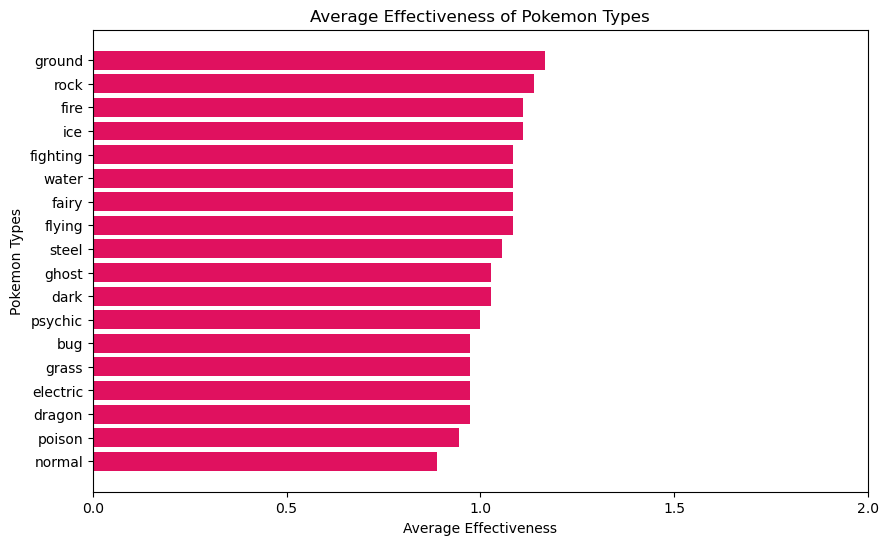

In [16]:
# Create bar chart
plt.figure(figsize=(10, 6))
plt.barh(pokemon_type_adv_df_numeric_sorted['my_types'], pokemon_type_adv_df_numeric_sorted['avg_effectiveness'], color='#E0115F')
plt.xlabel('Average Effectiveness')
plt.ylabel('Pokemon Types')
plt.title('Average Effectiveness of Pokemon Types')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest effectiveness at the top
# Set x-axis ticks in 0.5 ranges
plt.xticks(np.arange(0, 2.2, 0.5))
plt.show()

## Pokemon Team Suggestion 

### Opponents team of 6 pokemon from world championship roster

In [17]:
# List of 6 Pokemon of Pokemon World Championship runner up 2023
pokemon_ids = [379, 386, 195, 334, 197, 184]

# Query the database to get the details of the selected Pokémon
query = """
    SELECT name, primary_type, secondary_type
    FROM pokedex
    WHERE id IN ({})
""".format(','.join(map(str, pokemon_ids)))

result=execute_query(query)
# Convert the result to a pandas DataFrame
pokemon_team_df = pd.DataFrame(result, columns=['name','primary_type','secondary_type'])

# Display the selected Pokémon and their types
print("Selected Opponent Pokémon Details:")
pokemon_team_df


Selected Opponent Pokémon Details:


,name,primary_type,secondary_type
0,azumarill,water,fairy
1,quagsire,water,ground
2,umbreon,dark,None
3,altaria,dragon,flying
4,registeel,steel,None
5,deoxys-normal,psychic,None


### Using the Pokemon Types of the Opponent for Suggesting the Types for User's Pokemon

In [18]:
# Concatenate primary_type and secondary_type columns separately
primary_types = pokemon_team_df['primary_type']
secondary_types = pokemon_team_df['secondary_type'].dropna()

# Combine both series into one, and then extract unique types
opponent_types = pd.concat([primary_types, secondary_types])

# Remove duplcate types from the list of types
opponent_types = opponent_types.unique().tolist()

# Add the prefix "opponent_" to each element in the opponent_types list
opponent_types_with_prefix = ['opponent_' + type for type in opponent_types]


# List of columns to include in the new DataFrame
columns_to_include = ['my_types'] + opponent_types_with_prefix

# Create the new DataFrame with selected columns
pokemon_types_adv_selection_df = pokemon_type_adv_df_numeric.loc[:, columns_to_include]

# Calculate the average effectiveness for each type against all other types
type_avg_effectiveness = pokemon_types_adv_selection_df.drop(columns=['my_types']).mean(axis=1)

# Add the average effectiveness values to the DataFrame
pokemon_types_adv_selection_df['avg_effectiveness'] = type_avg_effectiveness
pokemon_types_adv_selection_df_sorted = pokemon_types_adv_selection_df.sort_values(by='avg_effectiveness', ascending=False)

# Filter the DataFrame based on avg_effectiveness >= 1.0
recommended_types = pokemon_types_adv_selection_df_sorted[pokemon_types_adv_selection_df_sorted['avg_effectiveness'] > 1.0]

# Sort the DataFrame based on avg_effectiveness in descending order
recommended_types = recommended_types.sort_values(by='avg_effectiveness', ascending=False)

#creating a list of the types
recommended_types_list=recommended_types['my_types'].tolist()

# Display the recommended types
print("Recommended Pokémon Types:")
recommended_types[['my_types', 'avg_effectiveness']]


Recommended Pokémon Types:


,my_types,avg_effectiveness
14,ice,1.25
17,fairy,1.1875
1,fighting,1.0625
12,electric,1.0625
11,grass,1.0625
6,bug,1.0625
7,ghost,1.0625


### Suggesting of top 10 Pokemon for the User Based on recommended types and the Total Stats.

In [19]:
#Connecting to the pokemon_data Database
conn = sqlite3.connect('pokemon_data.db')


sql_query = """
SELECT p.id, p.name, p.primary_type, p.secondary_type,
       s.hp + s.attack + s.defense + s.special_attack + s.special_defense + s.speed AS total_stats,
       s.hp, s.attack, s.defense, s.special_attack, s.special_defense, s.speed
FROM pokedex p
JOIN stats s ON p.id = s.id
WHERE p.primary_type IN ({})
   OR p.secondary_type IN ({})
ORDER BY total_stats DESC;
""".format(','.join(['?'] * len(recommended_types)), ','.join(['?'] * len(recommended_types_list)))

# Execute the query with parameters
result = conn.execute(sql_query, recommended_types_list * 2)

# Fetch all rows
rows = result.fetchall()

# Close the database connection
conn.close()

# Convert the result to a pandas DataFrame
recommended_pokemon_df = pd.DataFrame(rows, columns=['id', 'name', 'primary_type', 'secondary_type', 'total_stats', 'hp', 'attack', 'defense', 'special_attack', 'special_defense', 'speed'])

#printing the Top 10 recommended Pokemon
print("The Top 10 Recommended Pokemon to have: ")
recommended_pokemon_df.head(10)

The Top 10 Recommended Pokemon to have: 


,id,name,primary_type,secondary_type,total_stats,hp,attack,defense,special_attack,special_defense,speed
0,487,giratina-altered,ghost,dragon,680.0,150.0,100.0,120.0,100.0,120.0,90.0
1,644,zekrom,dragon,electric,680.0,100.0,150.0,120.0,120.0,100.0,90.0
2,716,xerneas,fairy,None,680.0,126.0,131.0,95.0,131.0,98.0,99.0
3,792,lunala,psychic,ghost,680.0,137.0,113.0,89.0,137.0,107.0,97.0
4,1007,koraidon,fighting,dragon,670.0,100.0,135.0,115.0,85.0,100.0,135.0
5,1008,miraidon,electric,dragon,670.0,100.0,85.0,100.0,135.0,115.0,135.0
6,646,kyurem,dragon,ice,660.0,125.0,130.0,90.0,130.0,90.0,95.0
7,888,zacian,fairy,None,660.0,92.0,120.0,115.0,80.0,115.0,138.0
8,889,zamazenta,fighting,None,660.0,92.0,120.0,115.0,80.0,115.0,138.0
9,251,celebi,psychic,grass,600.0,100.0,100.0,100.0,100.0,100.0,100.0


In [20]:
recommended_pokemon_df

,id,name,primary_type,secondary_type,total_stats,hp,attack,defense,special_attack,special_defense,speed
0,487,giratina-altered,ghost,dragon,680.0,150.0,100.0,120.0,100.0,120.0,90.0
1,644,zekrom,dragon,electric,680.0,100.0,150.0,120.0,120.0,100.0,90.0
2,716,xerneas,fairy,None,680.0,126.0,131.0,95.0,131.0,98.0,99.0
3,792,lunala,psychic,ghost,680.0,137.0,113.0,89.0,137.0,107.0,97.0
4,1007,koraidon,fighting,dragon,670.0,100.0,135.0,115.0,85.0,100.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...
480,401,kricketot,bug,None,194.0,37.0,25.0,41.0,25.0,41.0,25.0
481,298,azurill,normal,fairy,190.0,50.0,20.0,40.0,20.0,40.0,20.0
482,872,snom,ice,bug,185.0,30.0,25.0,35.0,45.0,30.0,20.0
483,191,sunkern,grass,None,180.0,30.0,30.0,30.0,30.0,30.0,30.0
